In [1]:
import pathlib
import os
import pandas as pd
import pathlib
from pathlib import Path as WindowsPath
import seaborn as sns
import matplotlib.pyplot as plt

## imports

In [ ]:

list(pathlib.Path(r'C:\Program Files\Micro-Manager-nightly-markt').glob('*.cfg'))

[WindowsPath('C:/Program Files/Micro-Manager-nightly-markt/DCC_alone.cfg'),
 WindowsPath('C:/Program Files/Micro-Manager-nightly-markt/ImageJ.cfg'),
 WindowsPath('C:/Program Files/Micro-Manager-nightly-markt/MMConfig_demo.cfg'),
 WindowsPath('C:/Program Files/Micro-Manager-nightly-markt/test-dcc.cfg')]

In [2]:
#!cmd
#export MICROMANAGER_PATH=/path/to/installation
#mmcore use <some path or pattern>

## do only once for pymmcore-plus sanity tests

In [9]:
! mmcore --version

pymmcore-plus v0.13.7
pymmcore v11.5.0.73.0
MMCore vMMCore version 11.5.0
Device API version 73, Module API version 10


In [10]:
! mmcore list

ðŸ“� C:\Program Files
   * Micro-Manager-1.4 (active)


In [14]:
! mmcore use "C:\Program Files\Micro-Manager-nightly-markt"

using C:\Program Files\Micro-Manager-nightly-markt


In [12]:
! mmcore list

ðŸ“� C:\Program Files
   * Micro-Manager-nightly-markt (Dev. Interface 73) (active)
   â€¢ Micro-Manager-1.4


In [13]:
from pymmcore_plus import find_micromanager
print(find_micromanager())

C:\Program Files\Micro-Manager-nightly-markt


## start here: dcc load

In [3]:
from pymmcore_plus import CMMCorePlus
mmc = CMMCorePlus()
#mmc.loadSystemConfiguration(r'C:/Program Files/Micro-Manager-2.0.0/DCC_alone.cfg')
mmc.loadSystemConfiguration(r'C:/Program Files/Micro-Manager-nightly-markt/DCC_alone.cfg')

In [5]:
print(mmc.getLoadedDevices())
for dev in mmc.getLoadedDevices():
    print(dev, mmc.getDevicePropertyNames(dev))

('DCCHub', 'DCCModule1', 'Core')
DCCHub ('SimulateDevice', 'Simulated', 'UseModule1', 'UseModule2', 'UseModule3', 'UseModule4', 'UseModule5', 'UseModule6', 'UseModule7', 'UseModule8')
DCCModule1 ('BaseAddress', 'BusNumber', 'C1_GainHV', 'C1_Minus5V', 'C1_Overloaded', 'C1_Plus12V', 'C1_Plus5V', 'C2_DigitalOut', 'C2_Minus5V', 'C2_Plus12V', 'C2_Plus5V', 'C3_CoolerCurrentLimit', 'C3_CoolerCurrentLimitReached', 'C3_CoolerVoltage', 'C3_Cooling', 'C3_GainHV', 'C3_Minus5V', 'C3_Overloaded', 'C3_Plus12V', 'C3_Plus5V', 'ClearOverloads', 'EnableOutputs', 'ModuleNumber', 'ModuleType', 'SerialNumber', 'SlotNumber')
Core ('AutoFocus', 'AutoShutter', 'Camera', 'ChannelGroup', 'Focus', 'Galvo', 'ImageProcessor', 'Initialize', 'SLM', 'Shutter', 'TimeoutMs', 'XYStage')


In [6]:
mmc.getAvailableConfigGroups()

('ENABLE', 'GAIN CONTROL PERCENT', 'Supply')

In [7]:
device_adapter_names = mmc.getDeviceAdapterNames()
[k for k in device_adapter_names if k.find('BH')>-1]

['BH_DCC', 'BH_DCC_DCU']

In [8]:
from pymmcore_plus import Device, DeviceProperty

In [9]:
device = mmc.getDeviceObject('DCCHub')
device.load('BH_DCC_DCU', 'DCCHub') 
#device.initialize()
for prop in device.properties:
    print(prop.name, prop.value) 

SimulateDevice No
Simulated No
UseModule1 Yes
UseModule2 No
UseModule3 No
UseModule4 No
UseModule5 No
UseModule6 No
UseModule7 No
UseModule8 No


C:\Users\lociuser\code\timetagger-scripts\.venv\Lib\site-packages\pymmcore_plus\core\_mmcore_plus.py:383: UserWarning: The specified device label "DCCHub" is already in use. Device 'DCCHub' appears to be loaded already.
  if exc := self._load_error_with_info(label, moduleName, deviceName, str(e)):


In [10]:
props = mmc.getDevicePropertyNames('DCCModule1')
for prop in props:
    print(prop) 

BaseAddress
BusNumber
C1_GainHV
C1_Minus5V
C1_Overloaded
C1_Plus12V
C1_Plus5V
C2_DigitalOut
C2_Minus5V
C2_Plus12V
C2_Plus5V
C3_CoolerCurrentLimit
C3_CoolerCurrentLimitReached
C3_CoolerVoltage
C3_Cooling
C3_GainHV
C3_Minus5V
C3_Overloaded
C3_Plus12V
C3_Plus5V
ClearOverloads
EnableOutputs
ModuleNumber
ModuleType
SerialNumber
SlotNumber


In [12]:
mmc.getProperty('DCCModule1', 'C3_CoolerVoltage'), mmc.getProperty('DCCModule1','C3_Cooling'),mmc.getProperty('DCCModule1','C3_CoolerCurrentLimit')

('0.0000', 'Off', '0.0000')

In [11]:
mmc.getProperty('DCCModule1', 'C1_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V')

('0.0000', 'Off', 'Off')

In [13]:
def start_PMT(mmc,gain=65,ch='C3'):
    mmc.setProperty('DCCModule1',ch+'_GainHV',gain)
    mmc.setProperty('DCCModule1','EnableOutputs','On')
    mmc.setProperty('DCCModule1',ch+'_Plus12V','On')
    mmc.waitForDevice('DCCModule1')

def stop_PMT(mmc,gain=0,ch='C3'):
    mmc.setProperty('DCCModule1',ch+'_GainHV',gain)
    mmc.setProperty('DCCModule1','EnableOutputs','Off')
    mmc.setProperty('DCCModule1',ch+'_Plus12V','Off')
    mmc.waitForDevice('DCCModule1')

def pmt_cooler(mmc):
    mmc.setProperty('DCCModule1', 'C3_CoolerVoltage',2.6) 
    mmc.setProperty('DCCModule1','C3_Cooling','On')
    mmc.setProperty('DCCModule1','C3_CoolerCurrentLimit',1.0)


In [35]:
from dataclasses import dataclass, asdict
from typing import Optional

@dataclass
class PMTChannelConfig:
    module: str = "DCCModule1"
    channel: str = "C3"
    gain_hv: float = 65.0
    enable_outputs: bool = True
    plus12v: bool = True
    cooler_voltage: Optional[float] = None
    cooler_on: bool = False
    cooler_current_limit: Optional[float] = None

    def apply(self, mmc):
        """Write this config into the MMCore device."""
        ch = self.channel
        m = self.module

        mmc.setProperty(m, f"{ch}_GainHV",      self.gain_hv)
        mmc.setProperty(m, "EnableOutputs",     "On" if self.enable_outputs else "Off")
        mmc.setProperty(m, f"{ch}_Plus12V",      "On" if self.plus12v       else "Off")

        if self.cooler_voltage is not None:
            mmc.setProperty(m, f"{ch}_CoolerVoltage", self.cooler_voltage)
        if self.cooler_on:
            mmc.setProperty(m, f"{ch}_Cooling",       "On")
        if self.cooler_current_limit is not None:
            mmc.setProperty(m, f"{ch}_CoolerCurrentLimit", self.cooler_current_limit)

        mmc.waitForDevice(m)

    def snapshot(self, mmc):
        """Read back every property into a dict."""
        ch = self.channel
        m  = self.module

        data = {
            "gain_hv":           float(mmc.getProperty(m, f"{ch}_GainHV")),
            "enable_outputs":    mmc.getProperty(m, "EnableOutputs") == "On",
            "plus12v":           mmc.getProperty(m, f"{ch}_Plus12V") == "On",
            "cooler_voltage":    float(mmc.getProperty(m, f"{ch}_CoolerVoltage")),
            "cooler_on":         mmc.getProperty(m, f"{ch}_Cooling") == "On",
            "cooler_current_limit": float(mmc.getProperty(m, f"{ch}_CoolerCurrentLimit")),
        }
        return data

    def set_gain(self, mmc, gain_hv: float):
        """Change only the high‑voltage gain (in %)."""
        self.gain_hv = gain_hv
        mmc.setProperty(self.module, f"{self.channel}_GainHV", gain_hv)
        mmc.waitForDevice(self.module)

    def turn_off_cooling(self, mmc):
        """Disable the cooler on this channel."""
        self.cooler_on = False
        mmc.setProperty(self.module, f"{self.channel}_Cooling", "Off")
        mmc.waitForDevice(self.module)

    def turn_off_pmt(self, mmc):
        """
        Fully power down the PMT channel:
         - set gain to 0%
         - outputs OFF
         - +12 V OFF
         - cooler OFF
        """
        m, ch = self.module, self.channel
        self.gain_hv = 0.0
        self.enable_outputs = False
        self.plus12v = False
        self.cooler_on = False

        mmc.setProperty(m, f"{ch}_GainHV",      0.0)
        mmc.setProperty(m, "EnableOutputs",     "Off")
        mmc.setProperty(m, f"{ch}_Plus12V",      "Off")
        mmc.setProperty(m, f"{ch}_Cooling",      "Off")
        mmc.waitForDevice(m)

    def destroy(self, mmc):
        self.turn_off_pmt(mmc)
        
import time
def sweep_gain(mmc, config: PMTChannelConfig,
               start: int=45, stop: int=85, step: int=5, sleep_sec = 2):
    
    for g in range(start, stop+1, step):
        config.set_gain(mmc, g)
        #results[g] = config.snapshot(mmc)
        print(config.snapshot(mmc)['gain_hv'])
        time.sleep(sleep_sec)

In [25]:
cfg = PMTChannelConfig(
    module="DCCModule1", channel="C3",
    gain_hv=70, enable_outputs=True, plus12v=True,
    cooler_voltage=2.6, cooler_on=True, cooler_current_limit=1.0
)
cfg

PMTChannelConfig(module='DCCModule1', channel='C3', gain_hv=70, enable_outputs=True, plus12v=True, cooler_voltage=2.6, cooler_on=True, cooler_current_limit=1.0)

In [26]:
cfg.apply(mmc)
status = cfg.snapshot(mmc)
print("PMT status:", status)


PMT status: {'gain_hv': 70.0, 'enable_outputs': True, 'plus12v': True, 'cooler_voltage': 2.6, 'cooler_on': True, 'cooler_current_limit': 1.0}


In [27]:
cfg.apply(mmc)
status = cfg.snapshot(mmc)
print("PMT status:", status)


PMT status: {'gain_hv': 70.0, 'enable_outputs': True, 'plus12v': True, 'cooler_voltage': 2.6, 'cooler_on': True, 'cooler_current_limit': 1.0}


In [28]:
cfg.gain_hv, cfg.enable_outputs

(70, True)

In [36]:
sweep_gain(mmc,cfg)

45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0


In [39]:
cfg.turn_off_pmt(mmc)

In [ ]:
from TimeTagger import TimeTagger, HistogramLogBins
tagger = TimeTagger.createTimeTagger()
# click_channel is your PMT channel, start_channel can be unused or your sync
cfg.apply()
hist = HistogramLogBins(tagger,
                       click_channel=-1,
                       start_channel=1,   # or your laser‑sync channel
                       exp_start=100,      # bin width in ps
                       n_bins=100) 
#classHistogramLogBins(tagger, click_channel, start_channel, exp_start, ex_stop, n_bins, click_gate=None, start_gate=None)
cfg.turn_off_pmt()

In [74]:

start_PMT(mmc)
print(mmc.getProperty('DCCModule1', 'C3_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V'))
stop_PMT(mmc)
print(mmc.getProperty('DCCModule1', 'C3_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V'))

65.0000 On On
0.0000 Off Off


## time tagger

In [59]:
from pymmcore_plus import CMMCorePlus
mmc = CMMCorePlus()
#mmc.loadSystemConfiguration(r'C:/Program Files/Micro-Manager-2.0.0/DCC_alone.cfg')
mmc.loadSystemConfiguration(r'C:/Program Files/Micro-Manager-nightly-markt/DCC_alone.cfg')

In [51]:
print(mmc.getLoadedDevices())
for dev in core.getLoadedDevices():
    print(dev, core.getDevicePropertyNames(dev))

('DCCHub', 'DCCModule1', 'Core')
Core ('AutoFocus', 'AutoShutter', 'Camera', 'ChannelGroup', 'Focus', 'Galvo', 'ImageProcessor', 'Initialize', 'SLM', 'Shutter', 'TimeoutMs', 'XYStage')


In [18]:
mmc.getAvailableConfigGroups()

('ENABLE', 'GAIN CONTROL PERCENT', 'Supply')

In [27]:
device_adapter_names = mmc.getDeviceAdapterNames()
[k for k in device_adapter_names if k.find('BH')>-1]

['BH_DCC', 'BH_DCC_DCU']

In [33]:
from pymmcore_plus import Device, DeviceProperty

In [38]:
device = mmc.getDeviceObject('DCCHub')
device.load('BH_DCC_DCU', 'DCCHub') 
#device.initialize()
for prop in device.properties:
    print(prop.name, prop.value) 

SimulateDevice No
Simulated No
UseModule1 Yes
UseModule2 No
UseModule3 No
UseModule4 No
UseModule5 No
UseModule6 No
UseModule7 No
UseModule8 No


In [55]:
props = mmc.getDevicePropertyNames('DCCModule1')
for prop in props:
    print(prop) 

BaseAddress
BusNumber
C1_GainHV
C1_Minus5V
C1_Overloaded
C1_Plus12V
C1_Plus5V
C2_DigitalOut
C2_Minus5V
C2_Plus12V
C2_Plus5V
C3_CoolerCurrentLimit
C3_CoolerCurrentLimitReached
C3_CoolerVoltage
C3_Cooling
C3_GainHV
C3_Minus5V
C3_Overloaded
C3_Plus12V
C3_Plus5V
ClearOverloads
EnableOutputs
ModuleNumber
ModuleType
SerialNumber
SlotNumber


In [57]:
mmc.getProperty('DCCModule1', 'C1_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V')

('0.0000', 'Off', 'Off')

In [73]:
def start_PMT(mmc,gain=65,ch='C3'):
    mmc.setProperty('DCCModule1',ch+'_GainHV',gain)
    mmc.setProperty('DCCModule1','EnableOutputs','On')
    mmc.setProperty('DCCModule1',ch+'_Plus12V','On')
    mmc.waitForDevice('DCCModule1')

def stop_PMT(mmc,gain=0,ch='C3'):
    mmc.setProperty('DCCModule1',ch+'_GainHV',gain)
    mmc.setProperty('DCCModule1','EnableOutputs','Off')
    mmc.setProperty('DCCModule1',ch+'_Plus12V','Off')
    mmc.waitForDevice('DCCModule1')


In [74]:

start_PMT(mmc)
print(mmc.getProperty('DCCModule1', 'C3_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V'))
stop_PMT(mmc)
print(mmc.getProperty('DCCModule1', 'C3_GainHV'), mmc.getProperty('DCCModule1','EnableOutputs'),mmc.getProperty('DCCModule1','C3_Plus12V'))

65.0000 On On
0.0000 Off Off


## time tagger (duplicate?)

In [59]:
import TimeTagger as TT
from TimeTagger import Countrate, Counter

In [60]:
tagger = TT.createTimeTagger()
tagger.reset()
tagger.clearOverflows()


In [61]:
''' set variables and triggers ''' 

# input channels
pmt1_start = -1
pmt1_stop = 1

# trigger levels in V
tagger.setTriggerLevel(pmt1_start,-0.01)  


In [62]:
channels = [pmt1_start,pmt1_stop]

In [63]:
import matplotlib.pyplot as plt

In [64]:
import numpy as np

In [65]:
binwidth = 1E9
n_values = 5000
binwidth*n_values/1E12

5.0

In [66]:
import time

In [80]:
start_PMT(mmc)

5.0 sec


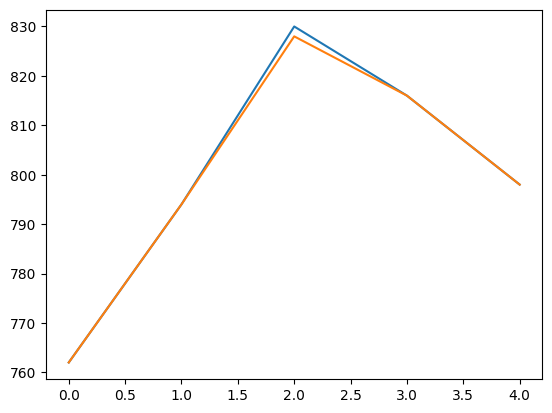

In [81]:
binwidth = 1000E9     # in ms
n_values = 5  # 
counter = Counter(tagger, channels, binwidth, n_values) 
counter.startFor(capture_duration=binwidth*n_values)
print(binwidth*n_values/1E12,'sec')
while counter.isRunning(): time.sleep(binwidth*n_values/1E12)
if not counter.isRunning():
    data = counter.getData()
    plt. plot(data.T,marker='.')

In [84]:
data,channels

(array([[762, 794, 830, 816, 798],
        [762, 794, 828, 816, 798]], dtype=int32),
 [-1, 1])

In [82]:
stop_PMT(mmc)

In [85]:
counter.getConfiguration()

{'name': 'Counter',
 'params': {'binwidth': 1000000000000, 'channels': [-1, 1], 'n values': 5},
 'registered channels': [-1, 1],
 'virtual channels': []}

In [86]:
channels

[-1, 1]

In [105]:
def get_darkcounts(collection_time_sec = 5, timing_resolution_sec=1):
    start_PMT(mmc)
    binwidth = timing_resolution_sec * 1E12     # in ms
    n_values = collection_time_sec/timing_resolution_sec  # 
    counter = Counter(tagger, channels, binwidth, n_values) 
    counter.startFor(capture_duration=binwidth*n_values)
    print("Collection time =",binwidth*n_values/1E12,'sec')
    while counter.isRunning(): time.sleep(binwidth*n_values/1E12)
    if not counter.isRunning():
        data = counter.getData()
    stop_PMT(mmc)
    return data

In [106]:
data =get_darkcounts(collection_time_sec=7,timing_resolution_sec=.1)

7.0 sec


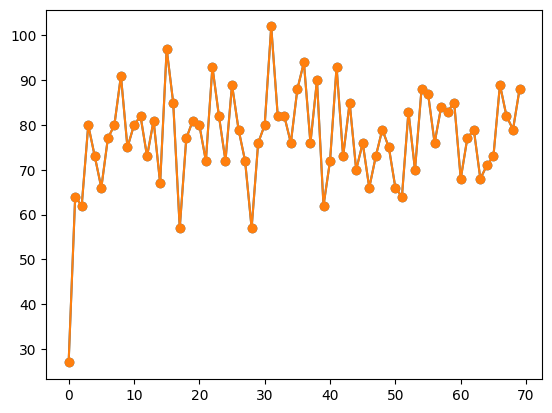

In [107]:
plt.plot(data.T,marker = 'o')

## plot logans data

In [3]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 2677-08A1

 Directory of c:\Users\lociuser\code\timetagger-scripts

04/19/2025  10:50 AM    <DIR>          .
04/19/2025  10:50 AM    <DIR>          ..
04/19/2025  04:24 AM               172 .gitignore
04/19/2025  10:32 AM    <DIR>          .ipynb_checkpoints
04/18/2025  04:04 PM    <DIR>          .venv
04/21/2025  04:55 PM    <DIR>          data
04/19/2025  04:00 AM           118,412 plot_time_trace.ipynb
04/19/2025  03:14 AM             2,770 plot_time_trace.py
04/19/2025  03:14 AM             4,363 plot_time_trace_mock.py
04/19/2025  12:23 PM    <DIR>          pmt_profiler
04/19/2025  03:17 AM    <DIR>          pmt_profiler.egg-info
04/19/2025  04:24 AM               903 pyproject.toml
04/19/2025  03:14 AM             1,715 README.md
04/19/2025  10:50 AM             2,701 Read_tekMDO32_data.ipynb
04/19/2025  03:14 AM               114 requirements.txt
04/18/2025  03:54 PM    <DIR>          swabianinstruments-web-demo
04/18/2025  03:52

In [5]:
list(pathlib.Path('data').glob('*.csv'))

[WindowsPath('data/dark_counts_20250419_042519.csv'),
 WindowsPath('data/dark_counts_20250419_042847.csv'),
 WindowsPath('data/dark_counts_20250419_044344.csv'),
 WindowsPath('data/dark_counts_20250419_044611.csv'),
 WindowsPath('data/dark_counts_20250419_044842.csv'),
 WindowsPath('data/dark_counts_20250419_045351.csv'),
 WindowsPath('data/dark_counts_20250419_110138.csv'),
 WindowsPath('data/dark_counts_20250419_110247.csv'),
 WindowsPath('data/dark_counts_20250419_110926_ctime_0.csv'),
 WindowsPath('data/dark_counts_20250419_111054_ctime_0.csv'),
 WindowsPath('data/dark_counts_20250419_111115_ctime_10.csv'),
 WindowsPath('data/dark_counts_20250421_160321_ctime_0.csv'),
 WindowsPath('data/dark_counts_20250421_160552_ctime_30.csv'),
 WindowsPath('data/dark_counts_20250421_161046_ctime_0_AP-SLIM-X-2012.csv'),
 WindowsPath('data/dark_counts_20250421_161257_ctime_30_AP-SLIM-X-2012.csv'),
 WindowsPath('data/dark_counts_20250421_163315_ctime_0.csv'),
 WindowsPath('data/dark_counts_20250421

dark_counts_20250421_161046_ctime_0_AP-SLIM-X-2012.csv (100, 3)


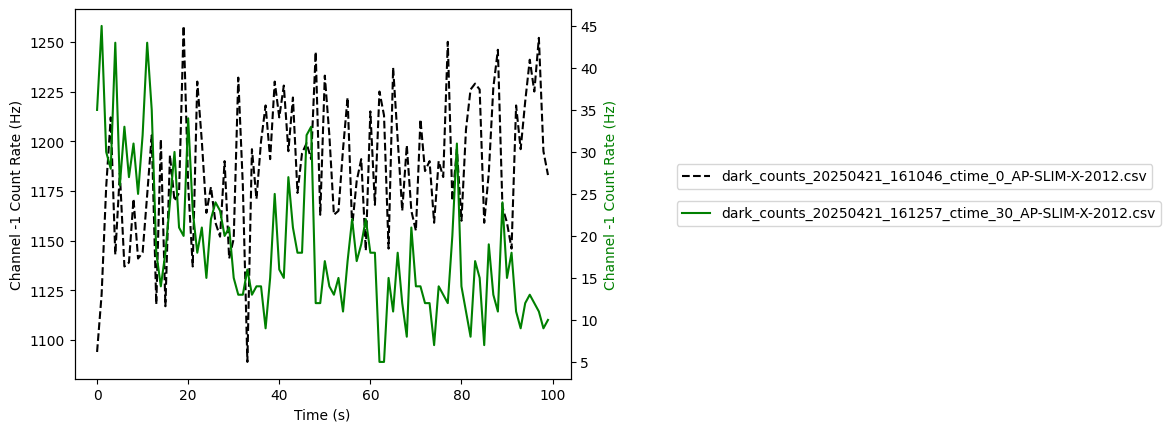

In [43]:

for i,j in [#[WindowsPath('data/dark_counts_20250421_160321_ctime_0.csv'),            WindowsPath('data/dark_counts_20250421_160552_ctime_30.csv')],
            [WindowsPath('data/dark_counts_20250421_161046_ctime_0_AP-SLIM-X-2012.csv'),            WindowsPath('data/dark_counts_20250421_161257_ctime_30_AP-SLIM-X-2012.csv')],
           # [WindowsPath('data/dark_counts_20250421_163315_ctime_0.csv'),            WindowsPath('data/dark_counts_20250421_163527_ctime_30.csv')],
           # [WindowsPath('data/dark_counts_20250421_164649_ctime_0.csv'),            WindowsPath('data/dark_counts_20250421_164820_ctime_30.csv')]
        ]:
    _,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    df1 = pd.read_csv(i)
    df2 = pd.read_csv(j)
    sns.lineplot(x=df1.columns[0],y=df1.columns[1],data=df1,label = i.name, ax=ax1, linestyle='--',color='k')
    print(i.name, df.shape) 
    sns.lineplot(x=df2.columns[0],y=df2.columns[1],data=df2,label = j.name, ax=ax2, linestyle='solid',color='g')
    ax2.set_ylabel(df1.columns[1], color='g')  # y-axis label color
    ax1.legend(  bbox_to_anchor=(1.2, 0.6))
    ax2.legend(  bbox_to_anchor=(1.2, 0.5))


In [19]:
import glob
fl = glob.glob(r'.\data\**\*.csv')
len(fl)

24

'C1vsC3Test_AA0903'

In [25]:
df = pd.DataFrame()
for ix,j in enumerate(sorted(fl[::2])):
    if j.find('AP-')>-1:        
        print(ix*2, fl[2*ix])
        print((2*ix)+1, fl[(2*ix)+1])
        dfx_warm = pd.read_csv(fl[2*ix])
        dfx_cooled = pd.read_csv(fl[(2*ix)+1])
        dfx_warm['cooler'] = False
        dfx_cooled['cooler'] = True
        dfx = pd.concat([dfx_warm,dfx_cooled])
        dfx['id1'] = j.split(os.sep)[2]
        df = pd.concat([df,dfx])
        print(df.shape)

0 .\data\AP-CAMM-X-2011_AA4661\dark_counts_20250424_114647_ctime_0.csv
1 .\data\AP-CAMM-X-2011_AA4661\dark_counts_20250424_114817_ctime_30.csv
(120, 5)
2 .\data\AP-OWS2-CH1-2012_AC0212\dark_counts_20250424_113516_ctime_0.csv
3 .\data\AP-OWS2-CH1-2012_AC0212\dark_counts_20250424_113647_ctime_30.csv
(240, 5)
4 .\data\AP-OWS2-X-2004_ZD4743\dark_counts_20250424_112655_ctime_0.csv
5 .\data\AP-OWS2-X-2004_ZD4743\dark_counts_20250424_112826_ctime_30.csv
(360, 5)
6 .\data\AP-OWS3-CH1-2022_AH0685\dark_counts_20250424_113030_ctime_0.csv
7 .\data\AP-OWS3-CH1-2022_AH0685\dark_counts_20250424_113200_ctime_30.csv
(480, 5)
8 .\data\AP-OWS3-CH2-2012_ZD3231\dark_counts_20250424_111957_ctime_0.csv
9 .\data\AP-OWS3-CH2-2012_ZD3231\dark_counts_20250424_112128_ctime_30.csv
(600, 5)
10 .\data\AP-OWS3-CH3-ND_AA0903\dark_counts_20250421_165044_ctime_0.csv
11 .\data\AP-OWS3-CH3-ND_AA0903\dark_counts_20250421_165214_ctime_30.csv
(720, 5)
12 .\data\AP-SLIM-X-2012_AA0574\dark_counts_20250424_111457_ctime_0.csv
13

In [27]:
df.columns

Index(['Time (s)', 'Channel -1 Count Rate (Hz)', 'Channel 1 Count Rate (Hz)',
       'cooler', 'id1'],
      dtype='object')

In [115]:
df.id1

0     AP-OWS2-X-2004_ZD4743
1     AP-OWS2-X-2004_ZD4743
2     AP-OWS2-X-2004_ZD4743
3     AP-OWS2-X-2004_ZD4743
4     AP-OWS2-X-2004_ZD4743
              ...          
55    AP-OWS3-CH3-ND_AA0903
56    AP-OWS3-CH3-ND_AA0903
57    AP-OWS3-CH3-ND_AA0903
58    AP-OWS3-CH3-ND_AA0903
59    AP-OWS3-CH3-ND_AA0903
Name: id1, Length: 1200, dtype: object

In [28]:
df.columns = ['time','ch1','ch1_rising','TECooler','id1']

In [121]:
df.columns

Index(['time', 'ch1', 'ch1_rising', 'TECooler', 'id1', 'loc', 'year', 'idx',
       'serial_number'],
      dtype='object')

In [158]:
dfx = df[['time', 'ch1', 'ch1_rising', 'TECooler', 'idx']].groupby(['TECooler','idx']).mean()[['ch1']].astype(int)
dfx.reset_index(inplace=True)
dfx = dfx.pivot(values=['ch1'],columns='TECooler',index='idx')
#dfx.to_excel('pmt_data.xlsx')
dfx

ch1      
TECooler  False True 
idx                  
2004 OWS2   316    27
2011 CAMM   105     7
2012 OWS2   413    46
2012 OWS3    34     1
2012 SLIM   905    19
2022 OWS3   320     7
2022 SLIM   236     7
ND OWS3      72     2

In [162]:
dfx = df[['time', 'ch1', 'ch1_rising', 'TECooler', 'idx','serial_number']].groupby(['TECooler','idx','serial_number']).mean()[['ch1']].astype(int)
dfx.reset_index(inplace=True)
dfx = dfx.pivot_table(columns= ['TECooler'],values=['ch1'],index=['idx','serial_number'])
dfx.to_excel('pmt_data.xlsx')
dfx

ch1      
TECooler                  False True 
idx       serial_number              
2004 OWS2 ZD4743          316.0  27.0
2011 CAMM AA4661          105.0   7.0
2012 OWS2 AC0212          413.0  46.0
2012 OWS3 ZD3231           34.0   1.0
2012 SLIM AA0574          163.0   8.0
          AA5128         1152.0  20.0
          ZJ4401         1401.0  30.0
2022 OWS3 AH0685          320.0   7.0
2022 SLIM AH1673          236.0   7.0
ND OWS3   AA0903           72.0   2.0

In [146]:
df_pmt.head()

,Index,Model,S/N,Notes_JC,Darkcounts(TT),Column1,loc
0,1.0,H7422P-40(2012),AC0212,AP-OWS2-CH1-2012,NaN,NaN,OWS2
1,2.0,H7422P-40(2012),AA5128,AP-SLIM-X-2012,NaN,NaN,SLIM
2,3.0,H7422P-40(2012),AA0574,AP-SLIM-X-2012,NaN,NaN,SLIM
3,4.0,H7422P-40(2012),ZD3231,AP-OWS3-CH2-2012,NaN,NaN,OWS3
4,5.0,H7422P-40(2011),AA4661,AP- CAMM-X-2011,NaN,NaN,CAMM


In [60]:
df_pmt = pd.read_excel(r'D:\UserData\Logan\PMT_Char\PMTs.xlsx',header=1)
#f_pmt.columns = ['ix', 'PMT', 'Ser_Num', 'id1', 'darkc','_']
df_pmt.head()

,Index,Model,S/N,Notes_JC,Darkcounts(TT),Column1
0,1.0,H7422P-40(2012),AC0212,AP-OWS2-CH1-2012,NaN,NaN
1,2.0,H7422P-40(2012),AA5128,AP-SLIM-X-2012,NaN,NaN
2,3.0,H7422P-40(2012),AA0574,AP-SLIM-X-2012,NaN,NaN
3,4.0,H7422P-40(2012),ZD3231,AP-OWS3-CH2-2012,NaN,NaN
4,5.0,H7422P-40(2011),AA4661,AP- CAMM-X-2011,NaN,NaN


In [61]:
df_pmt

,Index,Model,S/N,Notes_JC,Darkcounts(TT),Column1
0,1.0,H7422P-40(2012),AC0212,AP-OWS2-CH1-2012,NaN,NaN
1,2.0,H7422P-40(2012),AA5128,AP-SLIM-X-2012,NaN,NaN
2,3.0,H7422P-40(2012),AA0574,AP-SLIM-X-2012,NaN,NaN
3,4.0,H7422P-40(2012),ZD3231,AP-OWS3-CH2-2012,NaN,NaN
4,5.0,H7422P-40(2011),AA4661,AP- CAMM-X-2011,NaN,NaN
5,6.0,H7422P-40(2012),ZJ4401,AP-SLIM-X-2012,NaN,NaN
6,7.0,H7422P-40(2022),AH1673,AP-SLIM-X-2022,NaN,NaN
7,8.0,H7422P-40(2022),AH0685,AP-OWS3-X-2022,NaN,NaN
8,9.0,H7422P-40(2004)MOD,ZD4743,AP-OWS2-X-2004,NaN,NaN
9,10.0,H7422P-40(UNK)MOD,AA0903,AP-OWS3-CH3-X,NaN,NaN


In [ ]:
#df_pmt['loc'] = [str(l).split('-')[1] for l in df_pmt.Notes_JC.values]
#df_pmt['loc'] = [str(l).split('-')[1] for l in df_pmt.Notes_JC.values]

In [68]:
#set(df.id1.unique()).union(set(df_pmt.Notes_JC.unique()))

In [70]:
#df.columns, df_pmt.columns

In [71]:
#df.id1.unique()

In [76]:
df.id1.unique()

array(['AP-CAMM-X-2011_AA4661', 'AP-OWS2-CH1-2012_AC0212',
       'AP-OWS2-X-2004_ZD4743', 'AP-OWS3-CH1-2022_AH0685',
       'AP-OWS3-CH2-2012_ZD3231', 'AP-OWS3-CH3-ND_AA0903',
       'AP-SLIM-X-2012_AA0574', 'AP-SLIM-X-2012_AA5128',
       'AP-SLIM-X-2012_ZJ4401', 'AP-SLIM-X-2022_AH1673'], dtype=object)

In [75]:
df['loc'] = [str(l).split('-')[1] for l in df.id1.values]

In [80]:
df['year'] = [l.split('-')[3].split('_')[0] for l in df.id1.values]

In [118]:
df.id1.unique()

array(['AP-OWS2-X-2004_ZD4743', 'AP-CAMM-X-2011_AA4661',
       'AP-OWS2-CH1-2012_AC0212', 'AP-OWS3-CH2-2012_ZD3231',
       'AP-SLIM-X-2012_AA0574', 'AP-SLIM-X-2012_AA5128',
       'AP-SLIM-X-2012_ZJ4401', 'AP-OWS3-CH1-2022_AH0685',
       'AP-SLIM-X-2022_AH1673', 'AP-OWS3-CH3-ND_AA0903'], dtype=object)

In [119]:
df['serial_number'] = [l.split('-')[3].split('_')[1] for l in df.id1.values]


In [82]:
df.sort_values(by=['year','loc'],inplace=True)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 0 to 59
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   time        1200 non-null   int64 
 1   ch1         1200 non-null   int64 
 2   ch1_rising  1200 non-null   int64 
 3   TECooler    1200 non-null   bool  
 4   id1         1200 non-null   object
 5   loc         1200 non-null   object
 6   year        1200 non-null   object
dtypes: bool(1), int64(3), object(3)
memory usage: 66.8+ KB


In [90]:
print(df.dtypes)

time           int64
ch1            int64
ch1_rising     int64
TECooler        bool
id1           object
loc           object
year          object
dtype: object


In [92]:
df['idx'] = df['year'].astype(str) + ' ' + df['loc'].astype(str)

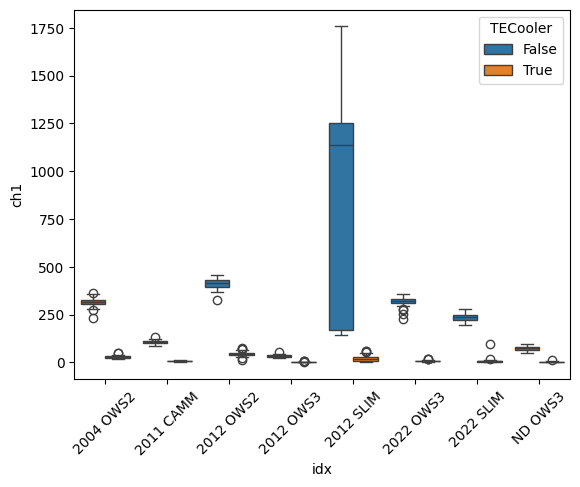

In [98]:
sns.boxplot(x='idx',y='ch1',data=df,hue='TECooler')
plt.xticks(rotation=45);

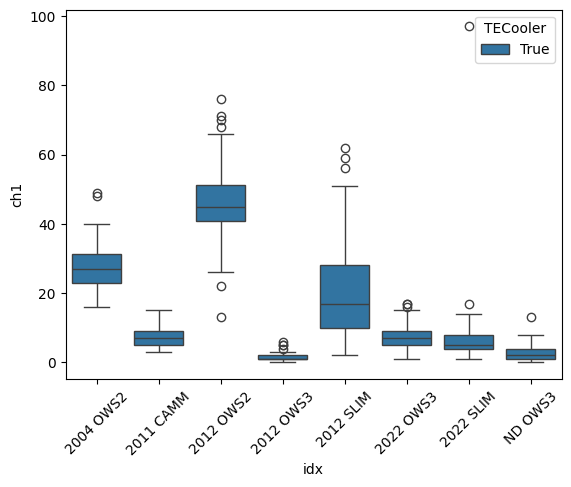

In [99]:
sns.boxplot(x='idx',y='ch1',data=df.loc[df.TECooler],hue='TECooler')
plt.xticks(rotation=45);

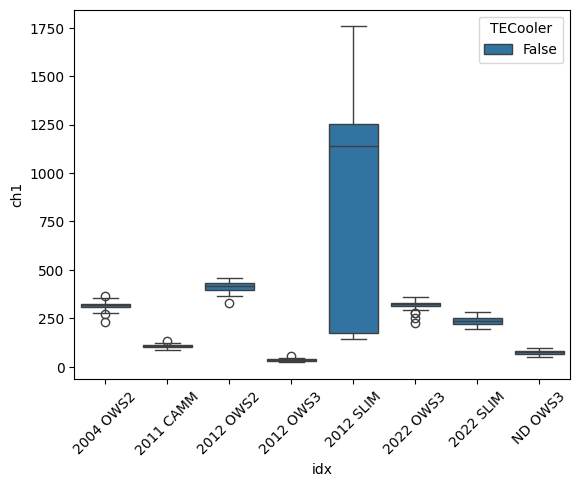

In [100]:
sns.boxplot(x='idx',y='ch1',data=df.loc[~df.TECooler],hue='TECooler')
plt.xticks(rotation=45);

In [163]:
df.shape

(1200, 9)

In [171]:
import numpy as np
from scipy import stats

AP-OWS2-X-2004_ZD4743 317 316
AP-CAMM-X-2011_AA4661 105 105
AP-OWS2-CH1-2012_AC0212 414 413
AP-OWS3-CH2-2012_ZD3231 34 34
AP-SLIM-X-2012_AA0574 163 163
AP-SLIM-X-2012_AA5128 1156 1152
AP-SLIM-X-2012_ZJ4401 1401 1401
AP-OWS3-CH1-2022_AH0685 323 320
AP-SLIM-X-2022_AH1673 236 236
AP-OWS3-CH3-ND_AA0903 72 72


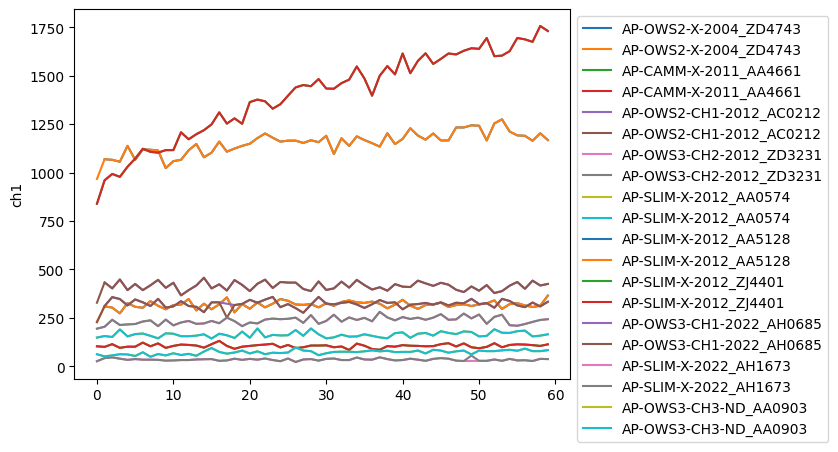

In [184]:
for k in df.id1.unique():
    dfxx = df.loc[(df.id1==k)].copy()
    series = dfxx.loc[~dfxx.TECooler]['ch1']
    series_clean = series[(np.abs(stats.zscore(series)) < 3)]
    sns.lineplot(series_clean,label=k)
    sns.lineplot(series,label=k)
    print(k, series_clean.mean().astype(int),series.mean().astype(int))
plt.legend(bbox_to_anchor=[1,1])

AP-OWS2-X-2004_ZD4743 27 27
AP-CAMM-X-2011_AA4661 7 7
AP-OWS2-CH1-2012_AC0212 46 46
AP-OWS3-CH2-2012_ZD3231 1 1
AP-SLIM-X-2012_AA0574 7 8
AP-SLIM-X-2012_AA5128 20 20
AP-SLIM-X-2012_ZJ4401 30 30
AP-OWS3-CH1-2022_AH0685 7 7
AP-SLIM-X-2022_AH1673 6 7
AP-OWS3-CH3-ND_AA0903 2 2


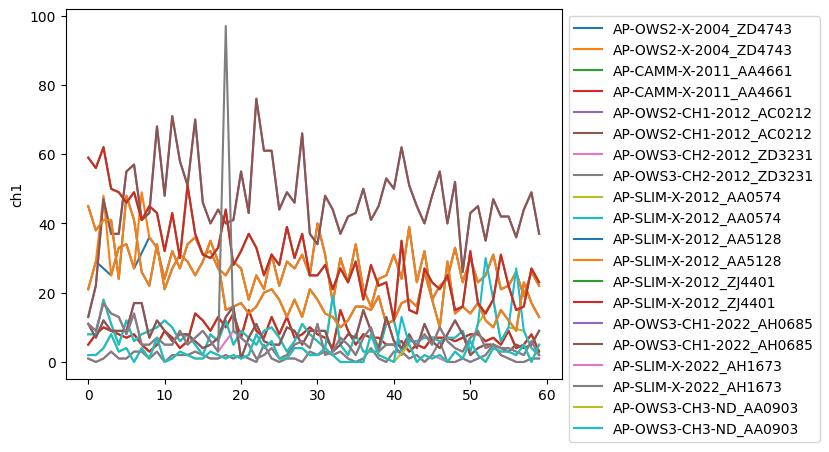

In [185]:
for k in df.id1.unique():
    dfxx = df.loc[(df.id1==k)].copy()
    series = dfxx.loc[dfxx.TECooler]['ch1']
    series_clean = series[(np.abs(stats.zscore(series)) < 3)]
    sns.lineplot(series_clean,label=k)
    sns.lineplot(series,label=k)
    print(k, series_clean.mean().astype(int),series.mean().astype(int))
plt.legend(bbox_to_anchor=[1,1])